# Fairness

Da wir in der Vorlesung inzwischen bei anwendungsbezogeneren Themen angekommen sind, wollen wir die verbliebenen Übungen nutzen, um Euch etwas freier an Aufgabenstellungen arbeiten zu lassen. Die Konzepte der Vorlesungen sollen dabei als Grundgedanken bei der Auswahl und Implementierung der Algorithmen einfließen. Heute soll es, passend zur Vorlesung, um Fairness gehen.

Seit vielen Jahren sind Risk Assessment Tools gebräuchlich in den Gerichten der USA. Sie sollen die Richter bei der Entscheidung über das Strafmaß unterstützen und als neutrale Komponente (ohne Bias) zum Prozess beitragen. Dabei kommt es regelmäßig vor, dass diese Tools maßgeblich die Entscheidung zu Haftdauer und Strafmaß beeinflussen und manchmal sogar die Vorschläge der Jury überstimmen.

Die Effektivität und Genauigkeit, sowie die Anwendung dieser Tools ist stark umstritten. Da es in dieser Übung um Fairness gehen soll, gehen wir erst einmal davon aus, dass die Modelle prinzipiell funktionieren und wir wollen uns vor allem auf die Auswirkungen auf einzelne Gruppen konzentrieren.

Das Risk Assessment Tool um das es in der Übung gehen soll ist *Correctional Offender Management Profiling for Alternative Sanctions (COMPAS)* vom Hersteller Northpointe. Dieses war 2016 groß in den Schlagzeilen als ProPublica, ein Netzwerk investigativer Journalisten, die Ergebnisse der Risikobewertung für ein County in Florida für die Jahre 2012/2013 unter dem Gesichtspunkt *Racial Bias*, insbesondere schwarze/weiße Amerikaner, untersuchte und zu dem Schluss kam, dass es einen starken Bias gegen schwarze Amerikaner gebe.

COMPAS liefert eine Reihe Scores, welche auf 137 Features (Fragen) basieren, die entweder aus Fragebögen der Angeklagten oder der kriminellen Vorgeschichte hervorgehen. Dabei wird *Race* explizit nicht abgefragt.

In der Übung betrachten wir den *Decile Score* für "Risk of Recidivism" und wie gut dieser eine Rückfälligkeit innerhalb zwei Jahren nach Urteil vorhersagt, sprich ob der Angeklagte eine weitere Straftat im Zeitraum von zwei Jahren begeht (gekennzeichnet mit `two_year_recid`). Mit diesem Label wurde das COMPAS Modell auch trainiert. Der Score kann diskrete Werte von 1 bis 10 annehmen, wobei 1-4 als niedriges, 5-7 als mittleres und 8-10 als hohes Risiko der Rückfälligkeit eingestuft werden.

Außerdem gibt es auch den Decile Score für "Risk of Violence", welcher entsprechend das Risiko für Gewaltstraftaten angeben soll.

In der Übung soll nun also dieses Modell (COMPAS) unter den Fairnesskriterien, welche wir in der Vorlesung behandelt haben, untersucht werden.


**Hier noch ein paar Links zu der ProPublica Debatte:**

*Disclaimer: Es ist womöglich sinnvoll zuerst die Übung (unvoreingenommen) zu machen und selbst herauszufinden was einem auffällt. Die Übung soll keine politische Stellungname bilden, sondern soll nur die in der Vorlesung dargestellten Kriterien an einem realen und interessanten Beispiel anwenden.*


ProPublica Analyse: https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm


Außerdem sehr interessanter Vortrag zum Thema Fairness, welcher in Teilen auch COMPAS behandelt:

https://www.youtube.com/watch?v=p5yY2MyTJXA

Kritik an der Analyse von ProPublica gab es unter anderem von [Flores et al]: "It might be that the existing justice system is biased agains poor minorities due to a wide variety of reasons (including economic factors, policing patterns, prosecutorial behavior, and judicial biases), and therefore, regardless of the degree of bias, risk assessment tools informed by objective data can help *reduce* racial bias from its current level. It would be a shame if policymakers mistakenly thought that risk assessment tools were somehow worse than the status quo. Because we are at a time in history where there appears to be bipartisan political support for criminal justice reform, one poorly executed study that makes such absolute claims of bias should not go unchallenged. The gravity of this study's erroneous conclusions is exacerbated by the large-market outlet in which it was published."


## Aufgaben:
Ist der Score noch zu retten? Um das zu klären, gehen wir wie in der Vorlesung vor:

1. Frage:  Schaue zuerst die Daten an. Was sind hier geschützte Attribute?

2. Frage: Betrachte den Decile Score als den Output des Models (vgl. α in VL) und plotte die Verteilung der Scores in Abhängikeit der 2 Jahres Rückfälligkeit getrennt nach den geschützten Attributen. Prüfe ob der COMPAS Score calibriert ist bezüglich "Caucasian"/"Afican American". Kannst du Aussagen zur Sufficiency treffen?

2. Angenommen wir möchten vorhersagen, ob eine Person ein "hohes" Risiko oder "kein hohes" Risiko hat rückfällig zu werden. Ist das Kriterium der Independence für die betroffenen Gruppen erfüllt? (Hilfe siehe unten)

3. Wie müssen wir den Schwellwert auf den Score für unsere Entscheidung legen um die Vorhersagegenauigkeit zur Rückfälligkeit für Menschen der Gruppen "Caucasian" zu maximieren?
Wende das Prinzip der Independence an um den Schwellwert für die Gruppe "African-American" zu ermitteln.

4. Kann das Kriterium der Separation für diese beiden Gruppen erfüllt werden? Unter welchen Vorrausetzungen ist dies der Fall? Nutze die ROC-Kurve dazu. Wie sehen die Thresholds jeweils aus?

5. Zurück zur Sufficiency: Ist Sufficency für identische Schwellwerte für beide Gruppen erfüllt? Was passiert, wenn wir Separation fordern und entsprechende Schwellwerte auf den Score wählen? Lassen sich alle drei Kriterien gleichzeitig erfüllen?

*Tipp: Du kannst alle Aufgaben durch geschickte Plots beantworten. Außerdem sind unterhalb dieser Aufgabenstellung noch ein paar Hilfestellungen/Erinnerungen verfübar.*


Zuerst importieren wir wieder die Pakete, welche wir für die Übung benötigen. Seaborn ist eine erweiterte API für Matplotlib und ermöglicht einfache und hübsche Plots. Dann importieren wir die Daten und verschaffen uns einen ersten Überblick über die Spalten.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Dann laden wir die Daten von ProPublica

In [ ]:
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)
df.info()

Als **schützenswerte Attribute** fallen hier relativ schnell "race" und "sex" auf. Für diese Analyse werden wir uns an der Veröffentlichung von ProPublica orientieren und auf "race" beschränken.

ProPublica hat sich auf den Vergleich zwischen "Caucasian", also weiß gelesenen Menschen und "African-American", also schwarz gelesenen Menschen, fokussiert. Bei Inspektion der Daten stellt man schnell fest, dass die anderen Attribute in der Spalte `race`, also "Hispanic", "Native American", "Asian" und "Other" nicht oft genug auftauchen, um verlässliche Aussagen zu treffen. Daher werden auch wir nur diese Unterscheidung betrachten und unsere Daten entsprechend filtern:

In [ ]:
#ProPublica wendet zusätzlich folgenden Filter an, den wir aber ignorieren:
#df = df[(df.days_b_screening_arrest<=30)&(df.days_b_screening_arrest>=-30)]
df_focus = df[(df["race"]=="Caucasian") | (df["race"]=="African-American")]
df_focus.shape # wie wir sehen, sind nur 1064 der 7214 Datenpunkte weggefallen

In [ ]:
df_focus

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7207,10994,jarred payne,jarred,payne,2014-05-10,Male,1985-07-31,30,25 - 45,African-American,...,2,Low,2014-05-10,2015-10-22,2015-10-22,0,0,529,1,1
7208,10995,raheem smith,raheem,smith,2013-10-20,Male,1995-06-28,20,Less than 25,African-American,...,9,High,2013-10-20,2014-04-07,2014-04-27,0,0,169,0,0
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0


Als nächstes wollen wir die Verteilung der Scores in Anhängigkeit der Attribute und der 2 Jahres Rückfälligkeit (also der Zielgröße) plotten. Mit diesen Verteilungen können wir auch gleich das Kriterium der **Calibration** überprüfen.

In [ ]:
df_calib = pd.DataFrame(columns=['race','decile_score','relative_recidivism','group_score_probability'])
# Abhängigkeit des geschützten Attributes 'race':
for r in df_focus['race'].unique():
  _df = df_focus[(df.race==r)]
  # Iteration über Scores
  for s in np.sort(df_focus['decile_score'].unique()):
      # Folgende Größe gibt an, wie groß der Anteil an Leuten ist, die rückfällig geworden sind (wird für jeden Score neu berechnet)
      rel = np.divide(_df[(_df.decile_score==s)&(_df.two_year_recid==1)].shape[0],_df[(_df.decile_score==s)].shape[0])
      # Folgende Größe gibt an, wie groß der Anteil an Leuten ist, die diesen oder einen höheren Score zugewisen bekommen haben
      gprob = np.divide(_df[(_df.decile_score>=s)].shape[0],_df.shape[0])

      df_calib=df_calib.append({'race':r,'decile_score':s,'relative_recidivism':rel,'group_score_probability':gprob},ignore_index=True)

# Berechnung derselben Größen, wenn nicht nach 'race' unterteil wird:
for s in np.sort(df_focus['decile_score'].unique()):
    rel = np.divide(df_focus[(df_focus.decile_score==s)&(df_focus.two_year_recid==1)].shape[0],df[(df.decile_score==s)].shape[0])
    gprob = np.divide(df_focus[(df.decile_score>=s)].shape[0],df_focus.shape[0])
    df_calib=df_calib.append({'race':'-','decile_score':s,'relative_recidivism':rel,'group_score_probability':gprob},ignore_index=True)

Damit Calibration erfüllt ist, müssen folgende Plots Ursprungsgraden sein:

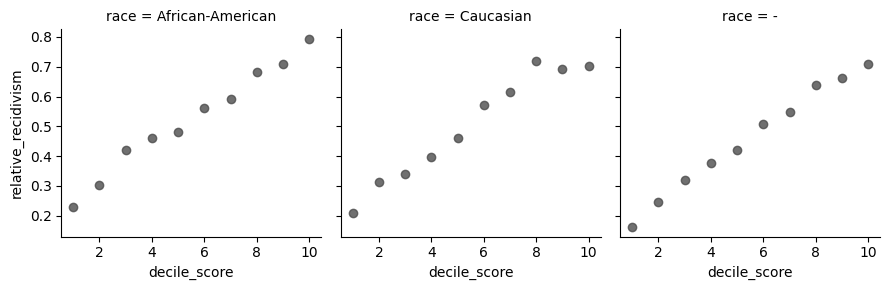

In [ ]:
g = sns.FacetGrid(df_calib, col="race", margin_titles=True)
g.map(sns.regplot, "decile_score", "relative_recidivism", color=".3", fit_reg=False)

Hier werden die beiden Plots nochmal übereinander gelegt:

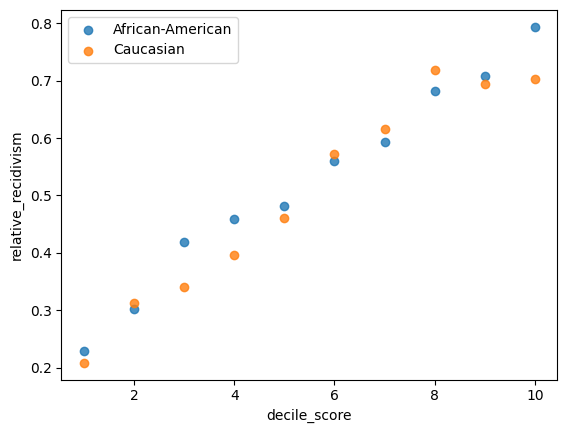

In [ ]:
sns.regplot(x="decile_score",y="relative_recidivism",data=df_calib[(df_calib.race=="African-American")],fit_reg=False,label="African-American")
sns.regplot(x="decile_score",y="relative_recidivism",data=df_calib[(df_calib.race=="Caucasian")],fit_reg=False,label="Caucasian")
plt.legend()

Eine Calibrations des Scores ist also annähernd gegeben! Aber: Wie wir aus der VL wissen, geht diese Calibration bei einer Binarisierung verloren und wir können keine Aussagen über das Kriterium der **Sufficiency** treffen.  

Wenn wir also, wie in Aufgabe 1 gefordert, unterscheiden wollen, ob eine Person ein "hohes Risiko" oder "kein hohes Risiko" hat, rückfällig zu werden, bringt uns dieser Plot nicht viel. Wir werden später noch auf Sufficiency zurück kommen.

Als nächstes wollen wir uns, wie von Aufgabe 2 gefordert, damit beschäftigen, ob **Independence**, also Unabhängigkeit, gegeben ist, wenn wir unterscheiden wollen, ob eine Person ein "hohes Risiko" oder "kein hohes Risiko" hat, rückfällig zu werden, Zur Erinnerung: Dafür muss gelten, dass die Wahrscheinlichkeit als rückfallgefährdet eingestuft zu werden, für beide Gruppen gleich ist: $P(\tilde{r}=1|\text{Gruppe}=\text{"Caucasian"}) \overset{!}{=} P(\tilde{r}=1|\text{Gruppe}=\text{"African-American"})$

Wir können auch dieses Kriteriums graphisch überprüfen. Wir plotten dafür auf der x-Achse den Score und auf der y-Achse den berechneten Anteil an Leuten, die diesen oder einen höheren Score zugewisen bekommen haben:

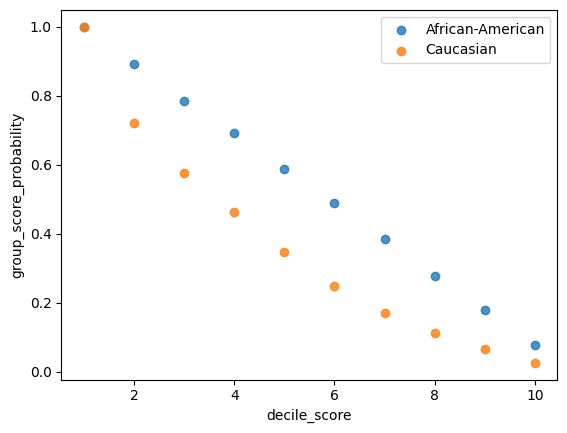

In [ ]:
sns.regplot(x="decile_score",y="group_score_probability",data=df_calib[(df_calib.race=="African-American")],fit_reg=False,label="African-American")
sns.regplot(x="decile_score",y="group_score_probability",data=df_calib[(df_calib.race=="Caucasian")],fit_reg=False,label="Caucasian")
plt.legend()

Um Independence zu gewährleisten, müssten also African-Americans erst ab einem 2 Punkte höheren Score als rückfallgefährdet eingestuft werden!

Für die restlichen Fragen binarisieren wir den Output in `0` für "niedriges Risiko" und `1` für "hohes Risiko" und definieren uns eine Funktion, die uns alle handelsüblichen Gütekriterien für Klassifikatoren abhängig vom Klassifikationsschwellwert ausgibt:

In [ ]:
# group_f = ["race"]
# score_text2_class = {"Low":0,"Medium":1,"High":1}

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

r_tilde_cauc = df_focus[df_focus.race=="Caucasian"]["decile_score"].to_numpy()
r_tilde_afr = df_focus[df_focus.race=="African-American"]["decile_score"].to_numpy()
r_cauc = df_focus[df_focus.race=="Caucasian"]["two_year_recid"].to_numpy()
r_afr = df_focus[df_focus.race=="African-American"]["two_year_recid"].to_numpy()

def print_stats(conf,group):
  #conf = [tn, fp; fn, tp]
  print(group)
  accuracy=(conf[0,0]+conf[1,1])/conf.sum()
  tpr = (conf[1,1])/(conf[1,0]+conf[1,1])
  fpr = (conf[0,1])/(conf[0,0]+conf[0,1])
  tnr = (conf[0,0])/(conf[0,1]+conf[0,0])
  fnr = (conf[1,0])/(conf[1,1]+conf[1,0])
  ppv= (conf[1,1])/(conf[0,1]+conf[1,1])
  npv=(conf[0,0])/(conf[0,0]+conf[1,0])
  probability_pred_revicid = (conf[0,1]+conf[1,1])/conf.sum()
  f1 = 2*conf[1,1]/(2*conf[1,1]+conf[0,1]+conf[1,0])

  print("-------------------------------")
  print("Accuracy: ", f"{accuracy:.4f}")
  print("True Positive Rate: ", f"{tpr:.4f}")
  print("False Positive Rate: ", f"{fpr:.4f}")
  #print("True Negative Rate: ", f"{tnr:.4f}")
  #print("False Negative Rate: ", f"{fnr:.4f}")
  print("PPV/Precision: ", f"{ppv:.4f}")
  print("NPV: ", f"{npv:.4f}")
  print("Probability of Predicted Revicidism: ", f"{probability_pred_revicid:.4f}")
  #print("F1-Score: ", f"{f1:.4f}")
  print("-------------------------------")
  return accuracy,tpr,fpr,ppv,npv,probability_pred_revicid

Für Aufgabe 3 wollen wir jetzt den Schwellwert für die Gruppe "Caucasian" $\alpha_{cauc}$ so finden, dass die Vorhersagegenauigkeit zur Rückfälligkeit für Menschen der Gruppen "Caucasian" maximiert wird. Durch ausprobieren finden wir $\alpha_{cauc}=6$, was zu einer Accuracy von $0.6777$ führt. Um Independence zu erreichen, muss der Schwellwert für die Gruppe "African-Amercian" $\alpha_{aa}$ also bei $8$ liegen.

In [ ]:
alpha_cauc = 6
alpha_aa = alpha_cauc+2 # Diesen Zusammenhang wissen wir aus dem letzten Plot
conf_cauc_compas = confusion_matrix(r_cauc,r_tilde_cauc>=alpha_cauc)
conf_afr_compas = confusion_matrix(r_afr,r_tilde_afr>=alpha_aa)
acc_cauc = print_stats(conf_cauc_compas,"Caucasian")[0]
acc_afr = print_stats(conf_afr_compas,"African-American")[0]

print(f'Mean accuracy: {(acc_afr*len(r_afr)+acc_cauc*len(r_cauc))/(len(r_afr)+len(r_cauc))}')

Caucasian
-------------------------------
Accuracy:  0.6777
True Positive Rate:  0.4079
False Positive Rate:  0.1472
PPV/Precision:  0.6427
NPV:  0.6893
Probability of Predicted Revicidism:  0.2498
-------------------------------
African-American
-------------------------------
Accuracy:  0.6093
True Positive Rate:  0.3898
False Positive Rate:  0.1582
PPV/Precision:  0.7229
NPV:  0.5657
Probability of Predicted Revicidism:  0.2773
-------------------------------
Mean accuracy: 0.6365853658536585


**Separation**, wie in Aufgabe 4 gefordert, ist wiederum erreicht, wenn TPR und FPR für beide Gruppen gleich sind. Mithilfe der ROC-Curve können wir feststellen, dass dieses Maximum bei einer TPR von ca. $0.65$ und einer FPR von ca. $0.35$ liegen muss:

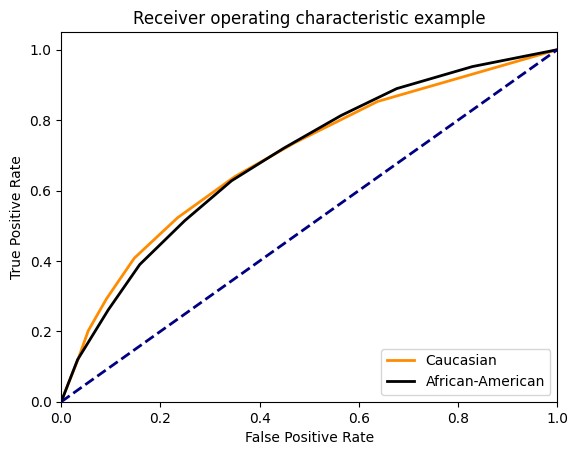

In [ ]:
from sklearn import metrics

fpr_cauc, tpr_cauc, thresholds_cauc = metrics.roc_curve(r_cauc, r_tilde_cauc)
fpr_afr, tpr_afr, thresholds_afr = metrics.roc_curve(r_afr, r_tilde_afr)

plt.figure()
lw = 2
plt.plot(fpr_cauc, tpr_cauc, color="darkorange", lw=lw, label="Caucasian")
plt.plot(fpr_afr, tpr_afr, color="black", lw=lw, label="African-American")

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

Diese Werte sind mit identischen Schwellwerten nicht erreichbar. Durch Ausprobieren stellen wir fest, dass $\alpha_{cauc}=4$ und $\alpha_{aa}=6$ mit ausreichender Genauigkeit zu diesen Werten führen. Im Vergleich zu vorhin ist allerdings die Gesamtaccuracy gesunken.

**Hinweis:** Die beiden ROC-Curves haben zwei weitere Schnittpunkte: Die Trivialfälle, bei den der Schwellwert bei 0 bzw. 11 liegt. Auch dann wäre Separation gegeben.

In [ ]:
alpha_cauc = 4
alpha_aa = 6
conf_cauc_compas = confusion_matrix(r_cauc,r_tilde_cauc>=alpha_cauc)
conf_afr_compas = confusion_matrix(r_afr,r_tilde_afr>=alpha_aa)
acc_cauc = print_stats(conf_cauc_compas,"Caucasian")[0]
acc_afr = print_stats(conf_afr_compas,"African-American")[0]

print(f'Mean accuracy: {(acc_afr*len(r_afr)+acc_cauc*len(r_cauc))/(len(r_afr)+len(r_cauc))}')

Caucasian
-------------------------------
Accuracy:  0.6459
True Positive Rate:  0.6398
False Positive Rate:  0.3501
PPV/Precision:  0.5426
NPV:  0.7354
Probability of Predicted Revicidism:  0.4641
-------------------------------
African-American
-------------------------------
Accuracy:  0.6418
True Positive Rate:  0.6276
False Positive Rate:  0.3432
PPV/Precision:  0.6595
NPV:  0.6248
Probability of Predicted Revicidism:  0.4894
-------------------------------
Mean accuracy: 0.6434146341463415


Kommen wir zurück zu **Sufficiency**: Diese ist erreicht, wenn PPV für beide Gruppen etwa gleich ist. Das ist für identische Schwellwerte gegeben. Wenn wir  außerdem die Gesamt-Accuracy maximieren wollen, wählen wir $\alpha_{cauc}=\alpha_{aa}=6$:



In [ ]:
alpha_cauc = 6
alpha_aa = 6
conf_cauc_compas = confusion_matrix(r_cauc,r_tilde_cauc>=alpha_cauc)
conf_afr_compas = confusion_matrix(r_afr,r_tilde_afr>=alpha_aa)
acc_cauc = print_stats(conf_cauc_compas,"Caucasian")[0]
acc_afr = print_stats(conf_afr_compas,"African-American")[0]

print(f'Mean accuracy: {(acc_afr*len(r_afr)+acc_cauc*len(r_cauc))/(len(r_afr)+len(r_cauc))}')

Caucasian
-------------------------------
Accuracy:  0.6777
True Positive Rate:  0.4079
False Positive Rate:  0.1472
PPV/Precision:  0.6427
NPV:  0.6893
Probability of Predicted Revicidism:  0.2498
-------------------------------
African-American
-------------------------------
Accuracy:  0.6418
True Positive Rate:  0.6276
False Positive Rate:  0.3432
PPV/Precision:  0.6595
NPV:  0.6248
Probability of Predicted Revicidism:  0.4894
-------------------------------
Mean accuracy: 0.6560975609756098


Wie schon in der Vorlesung angesprochen, ist es quasi unmöglich, alle Definitionen von Fairness gleichzeitig zu erfüllen. In unserem Einzelfall schaffen wir es mit $\alpha_{cauc}=4$ und $\alpha_{aa}=6$ zumindest Separation und Independence abzudecken. Dann können wir allerdings keine Sufficiency gewährleisten. Unterschiedliche Definitionen von Fairness sind auch ein Grund für die verschiedenen Interpretationen der ProPublica-Studie:

"*Specifically, it is (by COMPAS creator) argued that the COMPAS score is not biased against blacks because the likelihood of recidivism among high-risk offenders is the same regardless of race (predictive parity), it can discriminate between recidivists and nonrecidivists equally well for white and black defendants as measured with the area under the curve of the receiver operating characteristic, AUC-ROC (accuracy equity), and the likelihood of recidivism for any given score is the same regardless of race (calibration). The disagreement amounts to **different definitions of fairness**. In an eloquent editorial, Corbett-Davies et al. (6) explain that it is impossible to simultaneously satisfy all of these definitions of fairness because black defendants have a higher overall recidivism rate (in the Broward County data set, black defendants recidivate at a rate of 51% as compared with 39% for white defendants, similar to the national averages).*" - The accuracy, fairness, and limits of predicting recidivism, Dressel et al